In [281]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pandas as pd

import copulagp.marginal as mg
from copulagp import bvcopula
import torch
from scipy import interpolate

LENGTH = 200 #cm long VR corridor

def both_types_in_pos_bins(trials,pos,rate, n_bins=100,m=5):
    A_t0 = np.zeros((len(np.unique(trials[0])),n_bins))
    A_t1 = np.zeros((len(np.unique(trials[1])),n_bins))
    for A_tx, trial_num_tx, pos_tx, u_rate_tx in zip([A_t0,A_t1],
                                             trials,pos,rate):

        for j,trial in enumerate(np.unique(trial_num_tx)):
            pos = pos_tx[trial_num_tx==trial]
            for i in range(n_bins):
                mask = (pos>=(i-m)/n_bins) & (pos <=(i+1+m)/n_bins)
                if np.any(mask):
                    A_tx[j,i] = u_rate_tx[trial_num_tx==trial][mask].mean()

    return np.concatenate([A_t0,A_t1])


def plot_diff(data, cluster_id, file,
             n_bins = 200, m=5):
    [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    trial_num_t0 = trial_num[trial_type==0]
    trial_num_t1 = trial_num[trial_type==1]
    cond_y_t0 = data.iloc[cluster_id].cond_y_t0
    cond_y_t1 = data.iloc[cluster_id].cond_y_t1

    A=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[ds_rate_t0,ds_rate_t1],
                            n_bins=n_bins, m=m)
    B=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[cond_y_t0,cond_y_t1],
                            n_bins=n_bins, m=m)

    Hz_range = np.mean(A,axis=0).max(0)*0.5
    plt.imshow(A-B,vmin=-Hz_range,vmax=Hz_range,cmap="RdBu")
    plt.axhline(len(np.unique(trial_num_t0)),color='k',linestyle=':')
    plt.xticks([0,50],[0,100])
    plt.colorbar(label='<raw rate> - <conditional rate>')
    plt.xlabel('position, cm')
    plt.ylabel('trial #')
    plt.title(f'{data.iloc[cluster_id].session_id}, #{data.iloc[cluster_id].cluster_id}')
    # fig.colorbar(plot);
    plt.savefig(file)
    plt.close();
    
def plot_fr(data, cluster_id, file,
             n_bins = 200, m=5):
    [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    trial_num_t0 = trial_num[trial_type==0]
    trial_num_t1 = trial_num[trial_type==1]
    cond_y_t0 = data.iloc[cluster_id].cond_y_t0
    cond_y_t1 = data.iloc[cluster_id].cond_y_t1

    A=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[ds_rate_t0,ds_rate_t1],
                            n_bins=n_bins, m=m)
    
    Hz_range = np.mean(A,axis=0).max(0)*1.2 # mean FR at the location with the highest FR
    #     print(A.shape)
    plt.imshow(A,vmin=0,vmax=Hz_range)
    plt.axhline(len(np.unique(trial_num_t0)),color='k',linestyle=':')
    plt.xticks([0,50],[0,100])
    plt.colorbar(label='<raw rate> - <conditional rate>')
    plt.xlabel('position, cm')
    plt.ylabel('trial #')
    plt.title(f'{data.iloc[cluster_id].session_id}, #{data.iloc[cluster_id].cluster_id}')
    # fig.colorbar(plot);
    plt.savefig(file)
    plt.close();
    
def plot_diff_n_fr(data, cluster_id, file,
             n_bins = 200, m=5):
    fig,ax = plt.subplots(1,2)
    [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    trial_num_t0 = trial_num[trial_type==0]
    trial_num_t1 = trial_num[trial_type==1]
    cond_y_t0 = data.iloc[cluster_id].cond_y_t0
    cond_y_t1 = data.iloc[cluster_id].cond_y_t1

    A=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[ds_rate_t0,ds_rate_t1],
                            n_bins=n_bins, m=m)
    B=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[cond_y_t0,cond_y_t1],
                            n_bins=n_bins, m=m)

    Hz_range = np.mean(A,axis=0).max(0)*0.5
    ax[0].imshow(A-B,vmin=-Hz_range,vmax=Hz_range,cmap="RdBu")
    ax[0].axhline(len(np.unique(trial_num_t0)),color='k',linestyle=':')
    ax[0].set_xticks([0,50],[0,100])
#     ax[0].colorbar(label='<raw rate> - <conditional rate>')
    ax[0].set_xlabel('position, cm')
    ax[0].set_ylabel('trial #')
    ax[0].set_title(f'{data.iloc[cluster_id].session_id}, #{data.iloc[cluster_id].cluster_id}')
    
    Hz_range = np.mean(A,axis=0).max(0)*1.2 # mean FR at the location with the highest FR
    #     print(A.shape)
    ax[1].imshow(A,vmin=0,vmax=Hz_range)
    ax[1].axhline(len(np.unique(trial_num_t0)),color='k',linestyle=':')
    ax[1].set_xticks([0,50],[0,100])
#     ax[1].colorbar(label='<raw rate> - <conditional rate>')
    ax[1].set_xlabel('position, cm')
    ax[1].set_ylabel('trial #')
    ax[1].set_title(f'{data.iloc[cluster_id].session_id}, #{data.iloc[cluster_id].cluster_id}')
    
#     fig.colorbar(ax[0]);
    plt.savefig(file)
    plt.close();
    
    
    
    

In [282]:
import glob

cohorts = glob.glob("Cohort*")
cohort = cohorts[0]
cohort

'Cohort7_october2020'

In [283]:

session_list = glob.glob(f"unified_copula/{cohort}/*.pkl")
session_list
    

['unified_copula/Cohort7_october2020/M3_D23_2020-11-28_15-13-28_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M3_D8_2020-11-07_14-39-22_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M3_D28_2020-12-05_15-05-24_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M4_D12_2020-11-13_15-08-51_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M3_D21_2020-11-26_14-59-39_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M6_D17_2020-11-20_15-40-03_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M4_D6_2020-11-05_15-13-56_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M3_D29_2020-12-06_15-20-09_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M7_D30_2020-12-07_16-04-16_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M3_D24_2020-11-29_15-08-39_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M3_D25_2020-11-30_15-13-15_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M6_D23_2020-11-28_17-01-43_50ms_copula.pkl',
 'unified_copula/C

In [284]:
session_id=4
data = pd.read_pickle(session_list[session_id])
len(data)

40

In [285]:
diff_before_after=np.zeros((len(data),2))
for cluster_id in range(len(data)):
    [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]#/LENGTH
    pos_t1 = ds_pos[trial_type==1]#/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    cond_y_t0 = data.iloc[cluster_id].cond_y_t0
    cond_y_t1 = data.iloc[cluster_id].cond_y_t1

    diff_before_after[cluster_id] = (np.mean(np.abs(ds_rate_t0[pos_t0<90]-cond_y_t0[pos_t0<90])),np.mean(np.abs(ds_rate_t0[pos_t0>110]-cond_y_t0[pos_t0>110])))

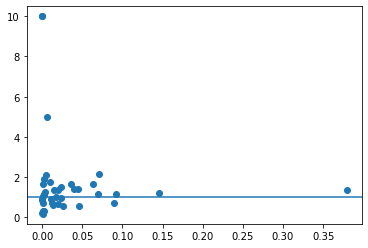

In [286]:
mask = diff_before_after[:,1]!=0

ratio = np.zeros_like(diff_before_after[:,0])
ratio[mask] = np.clip(diff_before_after[mask,0]/diff_before_after[mask,1],0,10.)

plt.scatter(diff_before_after[mask,0],ratio[mask])
plt.axhline(1.)
top=np.argmax(ratio[mask & (ratio!=10.)])
bottom=np.argmin(ratio[mask & (ratio!=0.)])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

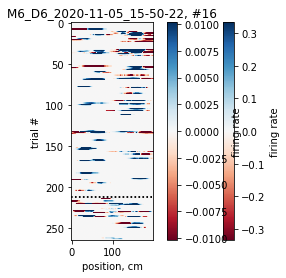

In [107]:
# plot_diff(data, cluster_id, )
session_name=(session_list[session_id].split('/')[-1]).split("_copula.pkl")[0]
save_name = lambda which: f"unified_copula/{cohort}/{session_name}_{which}.png"
plot_diff(data, top, save_name('top'))
# plot_diff(data, bottom, save_name('bottom'))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

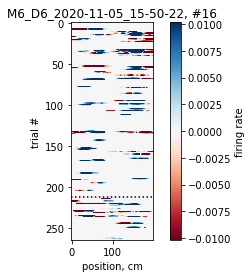

In [106]:
plot_diff(data, bottom, save_name('bottom'))

# Serialize

In [240]:
session_list = glob.glob(f"unified_copula/{cohort}/*.pkl")
for session in tqdm(session_list):
    data = pd.read_pickle(session)

    diff_before_after=np.zeros((len(data),2))
    for cluster_id in range(len(data)):
        [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
        pos = ds_pos%LENGTH
        cond_y = np.empty_like(ds_rate) 
        cond_y[trial_type==0] = data.iloc[cluster_id].cond_y_t0
        cond_y[trial_type==1] = data.iloc[cluster_id].cond_y_t1

        diff_before_after[cluster_id] = (np.mean(np.abs(ds_rate[pos<90]-cond_y[pos<90])),np.mean(np.abs(ds_rate[pos>110]-cond_y[pos>110])))
    
    mask = diff_before_after[:,1]!=0

    ratio = np.zeros_like(diff_before_after[:,0])
    ratio[mask] = np.clip(diff_before_after[mask,0]/diff_before_after[mask,1],0,10.)

    plt.scatter(diff_before_after[mask,0],ratio[mask])
    plt.axhline(1.)
    
    if len(ratio[mask & (ratio!=10.) & (ratio!=0.)])>0:
        top=np.max(ratio[mask & (ratio!=10.)])
        top_idx=np.argmax(ratio[mask & (ratio!=10.)])
        bottom=np.min(ratio[mask & (ratio!=0.)])
        bottom_idx=np.argmin(ratio[mask & (ratio!=0.)])

        session_name=(session.split('/')[-1]).split("_copula.pkl")[0]
        save_name = lambda which: f"unified_copula/{cohort}/{session_name}_{which}.png"
        plot_diff(data, top_idx, save_name('top'))
        plot_diff(data, bottom_idx, save_name('bottom'))

        if top>2.:
            save_name = f"interesting/effect_{cohort}_{session_name}.png"
            plot_diff(data, top_idx, save_name)

        if bottom<0.5:
            save_name = f"interesting/countereffect_{cohort}_{session_name}.png"
            plot_diff(data, bottom_idx, save_name)
    

    

  0%|          | 0/102 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [250]:
session_list = glob.glob(f"unified_copula/{cohort}/*.pkl")
ckpt_before,ckpt_after = 80,120
for session in tqdm(session_list):
    data = pd.read_pickle(session)

    diff_before_after=np.zeros((len(data),2))
    for cluster_id in range(len(data)):
        [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
        pos = ds_pos%LENGTH
        cond_y = np.empty_like(ds_rate) 
        cond_y[trial_type==0] = data.iloc[cluster_id].cond_y_t0
        cond_y[trial_type==1] = data.iloc[cluster_id].cond_y_t1

        diff_before_after[cluster_id] = (np.mean(np.abs(ds_rate[pos<ckpt_before]-cond_y[pos<ckpt_before])),
                                         np.mean(np.abs(ds_rate[pos>ckpt_after]-cond_y[pos>ckpt_after])))
    
    mask = diff_before_after[:,1]!=0

    ratio_dep = np.zeros_like(diff_before_after[:,0])
    ratio_dep[mask] = diff_before_after[mask,0]/diff_before_after[mask,1]
    
    diff_before_after=np.zeros((len(data),2))
    for cluster_id in range(len(data)):
        [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
        pos = ds_pos%LENGTH
        
        diff_before_after[cluster_id] = (np.mean(ds_rate[pos<ckpt_before]),np.mean(ds_rate[pos>ckpt_after]))
    
    mask = diff_before_after[:,1]!=0

    ratio_fr = np.zeros_like(diff_before_after[:,0])
    ratio_fr[mask] = diff_before_after[mask,0]/diff_before_after[mask,1]

    session_name=(session.split('/')[-1]).split("_copula.pkl")[0]
    
    assym_dep = ((ratio_dep>2.) & (ratio_dep<10.)) | ((ratio_dep<0.5) & (ratio_dep>0.1))
    sym_fr  =   (ratio_fr<1.2) & (ratio_fr >0.8)
    mask = assym_dep & sym_fr
    if np.any(mask):
        print('Assym dependence, sym FR:')
        print(session_name, data['cluster_id'][mask])
    
        for cluster_id in np.where(mask)[0]:
            print(cluster_id)
#             save_name = f"interesting/assym_dep_{cohort}_{session_name}_{cluster_id}.png"
#             plot_diff(data, cluster_id, save_name)
#             save_name = f"interesting/sym_fr_{cohort}_{session_name}_{cluster_id}.png"
#             plot_fr(data, cluster_id, save_name)
            save_name = f"interesting/assym_dep_sym_fr_{cohort}_{session_name}_{cluster_id}.png"
            plot_diff_n_fr(data, cluster_id, save_name)
#     mask = assym_dep & assym_fr
#     if np.any(mask):
#         print('Assym everything:')
#         print(session_name, data['cluster_id'][mask])
    

    

  0%|          | 0/102 [00:00<?, ?it/s]

Assym dependence, sym FR:
M3_D21_2020-11-26_14-59-39_50ms 11    12
Name: cluster_id, dtype: int64
4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


Assym dependence, sym FR:
M3_D19_2020-11-22_14-48-51_50ms 22    24
Name: cluster_id, dtype: int64
10


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


Assym dependence, sym FR:
M7_D7_2020-11-06_16-14-44_50ms 19    20
Name: cluster_id, dtype: int64
5


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


Assym dependence, sym FR:
M6_D3_2020-10-31_15-27-13_50ms 29    41
Name: cluster_id, dtype: int64
3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


Assym dependence, sym FR:
M6_D12_2020-11-13_15-44-22_50ms 28    29
32    33
Name: cluster_id, dtype: int64
11


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

13


/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Assym dependence, sym FR:
M7_D11_2020-11-12_16-22-33_50ms 9    10
Name: cluster_id, dtype: int64
5


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


Assym dependence, sym FR:
M7_D28_2020-12-05_16-15-10_50ms 3    4
5    6
Name: cluster_id, dtype: int64
1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

3


/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Assym dependence, sym FR:
M6_D10_2020-11-09_15-44-20_50ms 20    27
Name: cluster_id, dtype: int64
7


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


Assym dependence, sym FR:
M6_D11_2020-11-12_15-39-10_50ms 15    16
30    31
Name: cluster_id, dtype: int64
4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

10


/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Assym dependence, sym FR:
M6_D7_2020-11-06_15-37-15_50ms 32    33
Name: cluster_id, dtype: int64
12


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


Assym dependence, sym FR:
M4_D26_2020-12-03_15-28-32_50ms 6    7
Name: cluster_id, dtype: int64
0


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_40730/1060138831.py:109: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/1060138831.py:119: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


In [280]:
def plot_if_high_corr(data, cluster_id, file,
             n_bins = 200, m=5, ckpt_before=80,ckpt_after=120):
    [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    pos = ds_pos%LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    trial_num_t0 = trial_num[trial_type==0]
    trial_num_t1 = trial_num[trial_type==1]
    cond_y_t0 = data.iloc[cluster_id].cond_y_t0
    cond_y_t1 = data.iloc[cluster_id].cond_y_t1
    cond_y = np.empty_like(ds_rate) 
    cond_y[trial_type==0] = cond_y_t0
    cond_y[trial_type==1] = cond_y_t1

    
    diff_before_after = (np.mean(np.abs(ds_rate[pos<ckpt_before]-cond_y[pos<ckpt_before])),
                        np.mean(np.abs(ds_rate[pos>ckpt_after]-cond_y[pos>ckpt_after])))
   
    if (diff_before_after[1]!=0):
        ratio = diff_before_after[0]/diff_before_after[1]
    else:
        ratio = 0
        
    if ((ratio>2.) and (ratio<50.)) or ((ratio<.5) and (ratio>.02)):

        A=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[ds_rate_t0,ds_rate_t1],
                                n_bins=n_bins, m=m)
        B=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[cond_y_t0,cond_y_t1],
                                n_bins=n_bins, m=m)

        corr = np.array([np.corrcoef(a,a-b)[0,1] for a,b in zip(A,B)]) #trial-average temporal pattern corr
#         NOT time-average trial-to-trial variab -- if T
        print(np.mean(corr))
    #     print(np.corrcoef(A.flatten(),(A-B).flatten())[0,1])

        if (np.abs(np.mean(corr))>=0.25) and (np.abs(np.mean(corr))<0.5):
            print(data.iloc[cluster_id].session_id,cluster_id)
            fig,ax = plt.subplots(1,2)
            Hz_range = np.mean(A,axis=0).max(0)*0.5
            ax[0].imshow(A-B,vmin=-Hz_range,vmax=Hz_range,cmap="RdBu")
            ax[0].axhline(len(np.unique(trial_num_t0)),color='k',linestyle=':')
            ax[0].set_xticks([0,50],[0,100])
        #     ax[0].colorbar(label='<raw rate> - <conditional rate>')
            ax[0].set_xlabel('position, cm')
            ax[0].set_ylabel('trial #')
            ax[0].set_title(f'{data.iloc[cluster_id].session_id}, #{data.iloc[cluster_id].cluster_id}')

            Hz_range = np.mean(A,axis=0).max(0)*1.2 # mean FR at the location with the highest FR
            #     print(A.shape)
            ax[1].imshow(A,vmin=0,vmax=Hz_range)
            ax[1].axhline(len(np.unique(trial_num_t0)),color='k',linestyle=':')
            ax[1].set_xticks([0,50],[0,100])
        #     ax[1].colorbar(label='<raw rate> - <conditional rate>')
            ax[1].set_xlabel('position, cm')
            ax[1].set_ylabel('trial #')
            ax[1].set_title(f'{data.iloc[cluster_id].session_id}, #{data.iloc[cluster_id].cluster_id}')

        #     fig.colorbar(ax[0]);
            plt.savefig(file)
            plt.close();


    
session_list = glob.glob(f"unified_copula/{cohort}/*.pkl")
for session in tqdm(session_list):
    data = pd.read_pickle(session)
    session_name=(session.split('/')[-1]).split("_50ms_copula.pkl")[0]

    for cluster_id in range(len(data)):
#         print(cluster_id)
        save_name = f"interesting/uncorr2_{cohort}_{session_name}_{data.iloc[cluster_id].cluster_id}.png"
        plot_if_high_corr(data, cluster_id, save_name)
    

    

  0%|          | 0/102 [00:00<?, ?it/s]

0.33840172846821065
M3_D23_2020-11-28_15-13-28 0


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.1919725976324262
nan
nan
nan
nan
nan
0.3610234002328443
M4_D12_2020-11-13_15-08-51 0


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.2954764836382305
M3_D21_2020-11-26_14-59-39 4


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


nan
nan
nan
nan
nan
nan
nan
0.7233299386622397


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.8212597111584948
nan
0.822655496513677


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.6231093314178239
0.5953459833187896


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.41339673938340316
M3_D22_2020-11-27_15-01-24 3


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


nan
nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.49827875866529325
M4_D11_2020-11-12_15-03-41 2


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.4272340604512614
M6_D14_2020-11-15_15-37-28 4


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.22189647757855688
0.2372789557520976
0.3334214829260037
M3_D19_2020-11-22_14-48-51 17


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.6151511018803828


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.3060915919106939
M3_D6_2020-11-05_14-37-17 4


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.34986640930590585
M3_D18_2020-11-21_14-29-49 6


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.5143135382602688


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.2575955663908595
M6_D3_2020-10-31_15-27-13 3


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.3815901745446739
M7_D12_2020-11-13_16-20-54 1


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.2170069129753697
0.5245630521033926
nan
0.6175084833267056
0.38286742778308247
M6_D12_2020-11-13_15-44-22 7


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.5144419548704552
0.4285811198701552
M6_D12_2020-11-13_15-44-22 9
0.3063415496053331
M6_D12_2020-11-13_15-44-22 11
0.3942361769242349
M6_D12_2020-11-13_15-44-22 12
0.36010560050180795
M6_D12_2020-11-13_15-44-22 13


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.4057330994480938
M6_D15_2020-11-16_15-36-31 6


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.21366326242324724


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.5701749943214469
nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
nan
nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.5623495230300134
nan
0.6723717017001812
0.612612424140649


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.1214017048224696
0.6617313306727951


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.5229588676020176
0.5551030480282517


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.35983301794837463
M6_D9_2020-11-08_15-53-11 2


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.5430366439983195


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.4696114004646623
M6_D10_2020-11-09_15-44-20 0


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.6280424025996848
0.7344731649641096
0.654127178877607
0.6584970623883959


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
nan
nan
0.6910523598625289
nan
nan
nan
nan
0.5275686761677402
0.5264034975212473
0.5247000521258166
0.4784058434136309
M6_D6_2020-11-05_15-50-22 3


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.46340051416069367
M6_D13_2020-11-14_15-40-42 7


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.36292143484102485
M6_D13_2020-11-14_15-40-42 9
nan
0.4624373113700535
M3_D4_2020-11-01_14-12-26 1


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.3688157911846684
M3_D4_2020-11-01_14-12-26 2
0.5308596282119395


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.662685278995168
0.4525517910701362
M3_D15_2020-11-16_14-21-36 2


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.26784456054872885
M7_D17_2020-11-20_16-15-32 0


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.5919795436442606
0.4932147573359498
M3_D12_2020-11-13_14-27-08 4


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


0.4786901295696766
M7_D4_2020-11-01_16-05-43 2


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.3500752729351194
M6_D4_2020-11-01_15-27-08 0


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
0.37371778280549534
M6_D4_2020-11-01_15-27-08 2
nan
nan
0.3712770373286552
M6_D4_2020-11-01_15-27-08 12
0.5927204973229584
0.5146697464110231


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan
nan
0.46176975177997587
M4_D26_2020-12-03_15-28-32 0


/tmp/ipykernel_40730/2219265660.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([0,50],[0,100])
/tmp/ipykernel_40730/2219265660.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([0,50],[0,100])


nan


/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


session_id                               M3_D19_2020-11-22_14-48-51
cluster_id                                                       38
spikes_per50ms    [[0.5377058196210523, 0.6194029416737961, 0.68...
u_vel_t0          [0.03189159840785913, 0.04135798724802215, 0.0...
u_rate_t0         [0.623210386692468, 0.6586941595162012, 0.6687...
u_vel_t1          [0.0008488205493484025, 0.011890916881543357, ...
u_rate_t1         [0.9583726907637526, 0.9719340535907547, 0.975...
cond_y_t0         [0.25343558, 0.20591739, 0.2352699, 0.24926919...
theta_t0          [0.26118222, 0.24416612, 0.2285253, 0.2213113,...
cond_y_t1         [0.14107247, 0.23526499, 0.37400195, 0.2837915...
theta_t1          [0.31300482, 0.31005728, 0.30308995, 0.2912054...
Name: 35, dtype: object

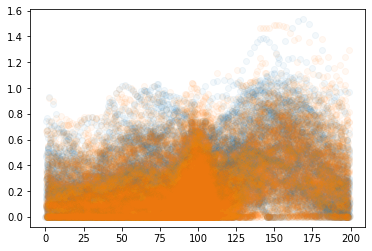

In [377]:
cohort='Cohort7_october2020'
session='M3_D19_2020-11-22_14-48-51'
# cluster_id=8
# glob.glob(f"unified_copula/{cohort}/*.pkl")
# data = pd.read_pickle(f"unified_copula/{cohort}/{session}_50ms_copula.pkl")
idx = 17 #data.loc[data['cluster_id']==38].index[0]
[ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[idx].spikes_per50ms
pos = ds_pos%LENGTH
cond_y = np.empty_like(ds_rate) 
cond_y[trial_type==0] = data.iloc[idx].cond_y_t0
cond_y[trial_type==1] = data.iloc[idx].cond_y_t1
# plt.plot(ds_rate[15000:16000])
# plt.plot(cond_y[15000:16000])
mask= trial_type==0
plt.scatter(pos[mask],ds_rate[mask],alpha=0.05)
plt.scatter(pos[mask],cond_y[mask],alpha=0.05)
data.iloc[idx]

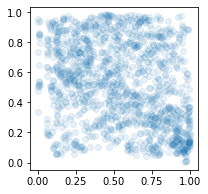

In [438]:
plt.figure(figsize=(3,3))
mask = (ds_pos[trial_type==1]>40) & (ds_pos[trial_type==1]<70)
plt.scatter(data.iloc[idx]['u_rate_t1'][mask],data.iloc[idx]['u_vel_t1'][mask],alpha=0.1)

In [441]:
mask2 = (data.iloc[idx]['u_rate_t0'][mask]>0.9) & (data.iloc[idx]['u_vel_t0'][mask]>0)
plt.hist(ds_vel[trial_type==0][mask][mask2])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 25749 but corresponding boolean dimension is 10303

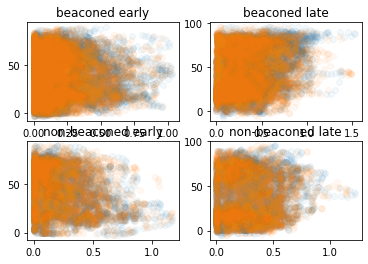

In [378]:
fig,ax = plt.subplots(2,2)
for i,trtype in enumerate([0,1]):
    for j,loc in enumerate([pos<90,pos>110]):
        mask= (trial_type==trtype) & loc
        ax[i,j].scatter(ds_rate[mask],ds_vel[mask],alpha=0.05)
        ax[i,j].scatter(cond_y[mask],ds_vel[mask],alpha=0.05)
        label = 'beaconed' if trtype==0 else 'non-beaconed'
        if j==0:
            label+= ' early'
        else:
            label+= ' late'
        ax[i,j].set_title(label)

In [196]:
data

,session_id,cluster_id,spikes_per50ms,u_vel_t0,u_rate_t0,u_vel_t1,u_rate_t1,cond_y_t0,theta_t0,cond_y_t1,theta_t1
3,M3_D12_2020-11-13_14-27-08,4,"[[0.30030827259930076, 0.31334082774228644, 0....","[0.00539229215316086, 0.00028041819928304026, ...","[0.7834108563446592, 0.8530118427242794, 0.917...","[0.9269002143033614, 0.8955792836251573, 0.895...","[0.5962571738189321, 0.5242971620561699, 0.442...","[0.11065247, 0.3307644, 0.329851, 0.655403, 0....","[0.31770542, 0.24084972, 0.15277915, 0.0889917...","[0.26430902, 0.40199658, 0.00703856, 0.0035364...","[0.6676749, 0.52037615, 0.30728093, 0.22238012..."
4,M3_D12_2020-11-13_14-27-08,5,"[[0.41509359052574507, 0.46343656521306914, 0....","[0.00539229215316086, 0.00028041819928304026, ...","[0.14103720846002127, 0.1659492614104774, 0.15...","[0.9269002143033614, 0.8955792836251573, 0.895...","[0.9942810914223076, 0.9820970815579277, 0.970...","[0.4381403, 0.40565914, 0.5178832, 0.36418813,...","[0.052671175, 0.085474834, 0.101750195, 0.0612...","[1.3646207, 1.2405572, 1.3557336, 1.1499431, 1...","[-0.009933183, -0.0048392387, 0.0049410574, 0...."
7,M3_D12_2020-11-13_14-27-08,8,"[[1.5482244910082241, 1.7808541027209497, 1.94...","[0.00539229215316086, 0.00028041819928304026, ...","[0.6765277016211623, 0.7645869100754146, 0.820...","[0.9269002143033614, 0.8955792836251573, 0.895...","[0.1258956575709539, 0.1926328115183835, 0.249...","[0.9671845, 1.1040044, 1.4624665, 1.4685125, 1...","[-0.16966562, -0.12392899, -0.076330766, -0.03...","[0.39416215, 0.4455008, 0.38780895, 0.5088829,...","[-0.34441635, -0.23662888, -0.067749165, 0.082..."
12,M3_D12_2020-11-13_14-27-08,13,"[[1.3025930655418014, 1.5431937212189568, 1.76...","[0.00539229215316086, 0.00028041819928304026, ...","[0.11004987518961007, 0.18321262883649653, 0.3...","[0.9269002143033614, 0.8955792836251573, 0.895...","[0.9724108856956996, 0.9266092670910635, 0.962...","[1.7772977, 2.235792, 2.1593757, 2.2007184, 2....","[0.43530446, 0.44442457, 0.44968975, 0.449933,...","[3.1384733, 3.2585435, 3.3764138, 3.3166625, 3...","[0.5754479, 0.4469414, 0.31616694, 0.30678183,..."
17,M3_D12_2020-11-13_14-27-08,19,"[[0.9784160419434094, 1.1529796245058157, 1.30...","[0.00539229215316086, 0.00028041819928304026, ...","[0.5203578715091286, 0.6113051082563007, 0.628...","[0.9269002143033614, 0.8955792836251573, 0.895...","[0.9533836371545233, 0.9503016150615176, 0.962...","[2.9880476, 3.2868423, 2.3548462, 2.5973053, 2...","[0.42559054, 0.49435058, 0.53036475, 0.5121226...","[1.7073735, 1.5453683, 1.4258745, 1.5429128, 1...","[0.52071494, 0.53794557, 0.5514262, 0.55584854..."
19,M3_D12_2020-11-13_14-27-08,21,"[[0.26762268731782013, 0.32289531084816503, 0....","[0.00539229215316086, 0.00028041819928304026, ...","[0.6294286579931712, 0.6914009787654618, 0.723...","[0.9269002143033614, 0.8955792836251573, 0.895...","[0.9707682837673677, 0.9704765016040166, 0.982...","[0.34169304, 0.36615178, 0.39797235, 0.5031723...","[-0.36010075, -0.33861965, -0.3149625, -0.2946...","[1.306152, 1.2291867, 1.1732879, 1.280916, 1.2...","[-0.389182, -0.35461834, -0.31847933, -0.28439..."
21,M3_D12_2020-11-13_14-27-08,23,"[[0.42971741297539706, 0.48929395188253477, 0....","[0.00539229215316086, 0.00028041819928304026, ...","[0.0818129027910118, 0.13095399221365342, 0.19...","[0.9269002143033614, 0.8955792836251573, 0.895...","[0.7745822341338143, 0.8144447978876914, 0.829...","[0.76085216, 0.9559255, 0.7853415, 0.8959726, ...","[0.25560626, 0.27383903, 0.28705338, 0.2861001...","[0.8963686, 0.9392618, 0.9620295, 0.9145656, 0...","[0.10843871, 0.117385626, 0.12559323, 0.128314..."
24,M3_D12_2020-11-13_14-27-08,26,"[[0.7292920657913868, 0.819440068429045, 0.886...","[0.00539229215316086, 0.00028041819928304026, ...","[0.8046749693416414, 0.8742700489886219, 0.884...","[0.9269002143033614, 0.8955792836251573, 0.895...","[0.8001826696213157, 0.7785052281666364, 0.771...","[0.8479643, 1.1397848, 0.8776385, 0.9608073, 0...","[-0.25040197, -0.21798423, -0.18855375,